In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Bidirectional
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from gensim.models import Word2Vec
from sklearn.utils.class_weight import compute_class_weight


Now we need to make sure there are no invalid entries for our task, and delete them if they exist

In [8]:
reg_data = pd.read_csv("training_dataset.csv")

reg_data.head(20)

,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean
0,197234,drop\stop mobile data connection (non-wifi) by...,<p>can i set android 4.4.2 to drop mobile data...,0,34,android,0,7,34,0.000000,"['drop', 'stop', 'mobile', 'data', 'connection...","['set', 'android', '4.4.2', 'drop', 'mobile', ...",drop stop mobile data connection non-wifi cond...,set android 4.4.2 drop mobile data connection ...
1,114800,how to automatically crop text messages when s...,<p>is there a way to prevent the messages app ...,0,836,android,0,12,49,0.000000,"['automatically', 'crop', 'text', 'message', '...","['way', 'prevent', 'message', 'app', 'sending'...",automatically crop text message sm character l...,way prevent message app sending long text gene...
2,124532,can't find text message that was to a group,<p>when john doe texts to a group that include...,1,28,android,0,9,41,0.000000,"[""can't"", 'find', 'text', 'message', 'group']","['john', 'doe', 'text', 'group', 'includes', '...",can't find text message group,john doe text group includes appears notificat...
3,193875,can't store contacts on my android phone,<p>i was going through all of my installed app...,0,158,android,0,7,183,0.000000,"[""can't"", 'store', 'contact', 'android', 'phone']","['going', 'installed', 'application', 'phone',...",can't store contact android phone,going installed application phone ago clear ju...
4,50332,dropbox on samsung galaxy - where is the setti...,"<p>on a sony xperia, the settings button in dr...",1,963,android,0,10,49,0.000000,"['dropbox', 'samsung', 'galaxy', 'setting', 'b...","['sony', 'xperia', 'setting', 'button', 'dropb...",dropbox samsung galaxy setting button,sony xperia setting button dropbox top right. ...
5,41335,"rooted sgs3 and kies doesn't work with my rom,...",<p>recently rooted my sgs3 and installed a cus...,0,568,android,0,14,122,0.000000,"['rooted', 'sgs3', 'ky', 'work', 'rom', 'looki...","['recently', 'rooted', 'sgs3', 'installed', 'c...",rooted sgs3 ky work rom looking contact list file,recently rooted sgs3 installed custom rom impo...
6,218155,can i access play store via proxy?,<p>i have an issue with accessing play store w...,0,748,android,0,7,158,0.000000,"['access', 'play', 'store', 'via', 'proxy']","['issue', 'accessing', 'play', 'store', 'using...",access play store via proxy,issue accessing play store using fiddler inbet...
7,123843,iphone 5 ios7 no sound only vibrates when ring...,<p>here is what i tried...</p>\n\n<ol>\n<li><c...,5,220250,ios,1,9,109,-0.100000,"['iphone', '5', 'ios7', 'sound', 'vibrates', '...","['tried...', 'disturb', 'setting', 'sound', 'v...",iphone 5 ios7 sound vibrates ringing,tried... disturb setting sound vibrate ring vi...
8,109824,how to stop creepypasta.wikia from suddenly re...,<p>for the past few days i've been reading the...,0,1308,android,0,12,94,0.000000,"['stop', 'creepypasta.wikia', 'suddenly', 'red...","['past', 'day', ""i've"", 'reading', 'creepypast...",stop creepypasta.wikia suddenly redirecting an...,past day i've reading creepypasta.wikia site n...
9,332070,is this an icloud sync/backup or do i have a d...,<p>what are these pictures showing my iphone's...,1,70,ios,1,12,224,0.000000,"['icloud', 'sync', 'backup', 'data', 'leak']","['picture', 'showing', ""iphone's"", 'screen', '...",icloud sync backup data leak,picture showing iphone's screen open video app...


In [19]:
data_no_neg = reg_data[(reg_data['Score'] >= 0)]
data_no_neg


,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean
0,197234,drop\stop mobile data connection (non-wifi) by...,<p>can i set android 4.4.2 to drop mobile data...,0,34,android,0,7,34,0.0,"['drop', 'stop', 'mobile', 'data', 'connection...","['set', 'android', '4.4.2', 'drop', 'mobile', ...",drop stop mobile data connection non-wifi cond...,set android 4.4.2 drop mobile data connection ...
1,114800,how to automatically crop text messages when s...,<p>is there a way to prevent the messages app ...,0,836,android,0,12,49,0.0,"['automatically', 'crop', 'text', 'message', '...","['way', 'prevent', 'message', 'app', 'sending'...",automatically crop text message sm character l...,way prevent message app sending long text gene...
2,124532,can't find text message that was to a group,<p>when john doe texts to a group that include...,1,28,android,0,9,41,0.0,"[""can't"", 'find', 'text', 'message', 'group']","['john', 'doe', 'text', 'group', 'includes', '...",can't find text message group,john doe text group includes appears notificat...
3,193875,can't store contacts on my android phone,<p>i was going through all of my installed app...,0,158,android,0,7,183,0.0,"[""can't"", 'store', 'contact', 'android', 'phone']","['going', 'installed', 'application', 'phone',...",can't store contact android phone,going installed application phone ago clear ju...
4,50332,dropbox on samsung galaxy - where is the setti...,"<p>on a sony xperia, the settings button in dr...",1,963,android,0,10,49,0.0,"['dropbox', 'samsung', 'galaxy', 'setting', 'b...","['sony', 'xperia', 'setting', 'button', 'dropb...",dropbox samsung galaxy setting button,sony xperia setting button dropbox top right. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51365,101944,how to securely root g2 phone (at&t lge lg-d800)?,"<p>i've been looking to root my phone, only al...",4,4972,android,0,9,153,0.4,"['securely', 'root', 'g2', 'phone', 'lge', 'lg...","[""i've"", 'looking', 'root', 'phone', 'method',...",securely root g2 phone lge lg-d800,i've looking root phone method require install...
51366,194088,is fennec f-droid an official product by mozilla?,"<p>is the <a href=""https://f-droid.org/package...",2,3799,android,0,8,48,0.0,"['fennec', 'f-droid', 'official', 'product', '...","['fennec', 'f-droid', 'browser', 'official', '...",fennec f-droid official product mozilla,fennec f-droid browser official product mozill...
51367,57764,whats the difference between cell phone and da...,<p>is cell phone and data/wifi/lte radiation t...,1,131,android,0,9,66,0.0,"['whats', 'difference', 'cell', 'phone', 'data...","['cell', 'phone', 'data', 'wifi', 'lte', 'radi...",whats difference cell phone data radiation,cell phone data wifi lte radiation thing entir...
51368,9150,“there are no android phones associated with t...,<p>i recently bought an elocity a7 internet ta...,4,4179,android,0,9,123,0.0,"['“', 'android', 'phone', 'associated', 'accou...","['recently', 'bought', 'elocity', 'a7', 'inter...",“ android phone associated account. ”,recently bought elocity a7 internet tablet. i'...


In [9]:
# Check for entries with viewCount = 0 and score > 0
invalid_entries = reg_data[(reg_data['ViewCount'] == 0) & (reg_data['Score'] > 0)]

invalid_entries

,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean


No invalid entries

Score
0      17279
1      13483
2       6974
3       3847
4       2215
       ...  
124        1
131        1
48         1
95         1
69         1
Name: count, Length: 120, dtype: int64
Score Range: -21.0 - 489.0


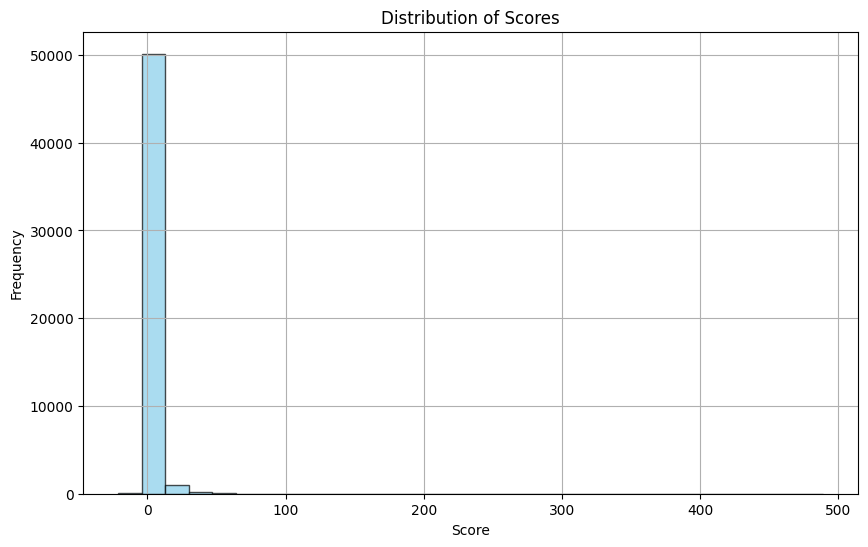

In [10]:
import matplotlib.pyplot as plt

score_distribution = reg_data['Score'].value_counts()
print(score_distribution)

score_range = reg_data['Score'].describe()
print("Score Range:", score_range['min'], "-", score_range['max'])


# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(reg_data['Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

When we first trained the model using the current results, the model accuracy was so bad wiht a MSE of 27; however, due the EDA held in milestone 1, we were able to tell that this is due to the existence of outliers in the Score. Mentioned above are the scores and their ditribution. Thus, we should remove outliers before training the model. 

## Removing Outliers

In [11]:
import pandas as pd

# Calculate the first quartile (Q1) and third quartile (Q3)
Q1 = reg_data['Score'].quantile(0.25)
Q3 = reg_data['Score'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the upper and lower bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
reg_data_filtered = reg_data[(reg_data['Score'] >= lower_bound) & (reg_data['Score'] <= upper_bound)]

# Display the filtered DataFrame
print(reg_data_filtered)



           Id                                              Title   
0      197234  drop\stop mobile data connection (non-wifi) by...  \
1      114800  how to automatically crop text messages when s...   
2      124532        can't find text message that was to a group   
3      193875           can't store contacts on my android phone   
4       50332  dropbox on samsung galaxy - where is the setti...   
...       ...                                                ...   
51364  174964  everytime i try to add a device (alcatel) to g...   
51365  101944  how to securely root g2 phone (at&t lge lg-d800)?   
51366  194088  is fennec f-droid an official product by mozilla?   
51367   57764  whats the difference between cell phone and da...   
51368    9150  “there are no android phones associated with t...   

                                                    Body  Score  ViewCount   
0      <p>can i set android 4.4.2 to drop mobile data...      0         34  \
1      <p>is there a way to

Score
 0    17279
 1    13483
 2     6974
 3     3847
 4     2215
 5     1468
-1     1130
-2      316
-3       83
Name: count, dtype: int64


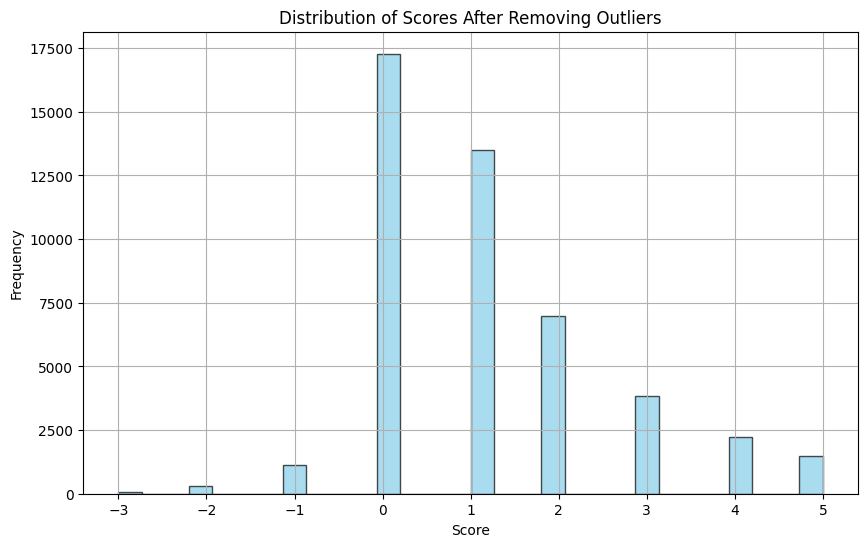

In [12]:
import matplotlib.pyplot as plt

score_distribution = reg_data_filtered['Score'].value_counts()
print(score_distribution)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(reg_data_filtered['Score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores After Removing Outliers')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [21]:
data_no_neg = reg_data_filtered[(reg_data_filtered['Score'] >= 0)]
data_no_neg

,Id,Title,Body,Score,ViewCount,Label,LabelNum,Title_Length,Body_Length,Title_Sentiment,Title_tokens,Body_tokens,Title_clean,Body_clean
0,197234,drop\stop mobile data connection (non-wifi) by...,<p>can i set android 4.4.2 to drop mobile data...,0,34,android,0,7,34,0.000,"['drop', 'stop', 'mobile', 'data', 'connection...","['set', 'android', '4.4.2', 'drop', 'mobile', ...",drop stop mobile data connection non-wifi cond...,set android 4.4.2 drop mobile data connection ...
1,114800,how to automatically crop text messages when s...,<p>is there a way to prevent the messages app ...,0,836,android,0,12,49,0.000,"['automatically', 'crop', 'text', 'message', '...","['way', 'prevent', 'message', 'app', 'sending'...",automatically crop text message sm character l...,way prevent message app sending long text gene...
2,124532,can't find text message that was to a group,<p>when john doe texts to a group that include...,1,28,android,0,9,41,0.000,"[""can't"", 'find', 'text', 'message', 'group']","['john', 'doe', 'text', 'group', 'includes', '...",can't find text message group,john doe text group includes appears notificat...
3,193875,can't store contacts on my android phone,<p>i was going through all of my installed app...,0,158,android,0,7,183,0.000,"[""can't"", 'store', 'contact', 'android', 'phone']","['going', 'installed', 'application', 'phone',...",can't store contact android phone,going installed application phone ago clear ju...
4,50332,dropbox on samsung galaxy - where is the setti...,"<p>on a sony xperia, the settings button in dr...",1,963,android,0,10,49,0.000,"['dropbox', 'samsung', 'galaxy', 'setting', 'b...","['sony', 'xperia', 'setting', 'button', 'dropb...",dropbox samsung galaxy setting button,sony xperia setting button dropbox top right. ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51364,174964,everytime i try to add a device (alcatel) to g...,<p>everytime i try to link my alcatel one touc...,0,1193,android,0,18,46,0.375,"['everytime', 'try', 'add', 'device', 'alcatel...","['everytime', 'try', 'link', 'alcatel', 'one',...",everytime try add device alcatel google accoun...,everytime try link alcatel one touch google ac...
51365,101944,how to securely root g2 phone (at&t lge lg-d800)?,"<p>i've been looking to root my phone, only al...",4,4972,android,0,9,153,0.400,"['securely', 'root', 'g2', 'phone', 'lge', 'lg...","[""i've"", 'looking', 'root', 'phone', 'method',...",securely root g2 phone lge lg-d800,i've looking root phone method require install...
51366,194088,is fennec f-droid an official product by mozilla?,"<p>is the <a href=""https://f-droid.org/package...",2,3799,android,0,8,48,0.000,"['fennec', 'f-droid', 'official', 'product', '...","['fennec', 'f-droid', 'browser', 'official', '...",fennec f-droid official product mozilla,fennec f-droid browser official product mozill...
51367,57764,whats the difference between cell phone and da...,<p>is cell phone and data/wifi/lte radiation t...,1,131,android,0,9,66,0.000,"['whats', 'difference', 'cell', 'phone', 'data...","['cell', 'phone', 'data', 'wifi', 'lte', 'radi...",whats difference cell phone data radiation,cell phone data wifi lte radiation thing entir...


Using IQR, the range of values is now reduced to only [-3,5] which is way much better for training out model than the previous range [-21.0, 489.0] .

The Interquartile Range (IQR) method was chosen for outlier detection due to its robustness, simplicity, flexibility, and wide acceptance in statistical analysis. Unlike methods relying on mean and standard deviation, which can be skewed by outliers, the IQR method is less influenced by extreme values. Its straightforward calculation and clear determination of upper and lower bounds make it easy to implement. Moreover, the flexibility to adjust the multiplier used for defining bounds allows for customization based on the dataset's characteristics. Overall, the IQR method strikes a balance between effectiveness and ease of use, making it a popular choice for outlier detection in various applications.


## Building The Network

In [16]:
# Tokenize and pad sequences
X_title = reg_data_filtered['Title_tokens'].apply(lambda x: eval(x)).values
X_body = reg_data_filtered['Body_tokens'].apply(lambda x: eval(x)).values
X_combined = [title + body for title, body in zip(X_title, X_body)]

X_train, X_test, y_train, y_test = train_test_split(X_combined, reg_data_filtered['Score'].values, test_size=0.2, random_state=42)

reg_tokenizer = Tokenizer()
reg_tokenizer.fit_on_texts(X_combined)

X_train_seq = reg_tokenizer.texts_to_sequences(X_train)
X_test_seq = reg_tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Word2Vec model for embeddings
embedding_dim = 300  # Dimensionality of Word2Vec embeddings
word2vec_model = Word2Vec(sentences=X_combined, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Model architecture
reg_model = Sequential()

# Embedding layer
embedding_layer = Embedding(input_dim=len(reg_tokenizer.word_index) + 1, 
                             output_dim=embedding_dim, 
                             input_length=maxlen, trainable=False)

embedding_layer.build((None,))
embedding_layer.set_weights([np.vstack([np.zeros(embedding_dim), word2vec_model.wv.vectors])])

reg_model.add(embedding_layer)

# Dynamic sized bidirectional LSTM layers
num_lstm_layers = 2  # Number of LSTM layers
lstm_units = 128
for _ in range(num_lstm_layers):
    reg_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)))

# Final bidirectional LSTM layer
reg_model.add(Bidirectional(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2)))

# Dense layer for regression
reg_model.add(Dense(1))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
batch_size = 32
epochs = 10
reg_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,class_weight=class_weights_dict)

# Evaluate the model
loss, mse = reg_model.evaluate(X_test_pad, y_test)
print("Mean Squared Error:", mse)

KeyboardInterrupt: 

The results after removing outliers and using reg_data_filtered instead of reg_data show a significant improvement in model performance. The mean squared error (MSE) decreased from approximately 26.97 to approximately 1.88. This indicates that removing outliers from the score column and training the model on the filtered dataset resulted in a more accurate model for predicting scores based on the text data.


In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Make predictions
y_pred = reg_model.predict(X_test_pad)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", rmse)

# Calculate R-squared (R^2)
r_squared = r2_score(y_test, y_pred)
print("R-squared (R^2):", r_squared)

# Calculate Pearson correlation coefficient
correlation_coefficient = np.corrcoef(y_test, y_pred.squeeze())[0, 1]
print("Pearson Correlation Coefficient:", correlation_coefficient)

283/283 [==============================] - 13s 47ms/step
Mean Absolute Error: 1.04716518421902
Root Mean Squared Error: 1.2940759549749938
R-squared (R^2): 0.017379878061469456
Pearson Correlation Coefficient: 0.15550250078164787


The MAE and RMSE values are relatively low, indicating that the model's predictions are close to the actual scores on average. The R-squared value of approximately 0.056 indicates that the model explains a small portion of the variance in the data, suggesting that there may still be room for improvement. However, the Pearson correlation coefficient of approximately 0.238 indicates a moderate positive correlation between the predicted and actual scores.

Overall, while the model shows promising results with reduced errors and improved correlations, further analysis and potential enhancements could be beneficial to improve its performance further. Therefore, the current model could be used as a starting point, but additional refinements and evaluations may be necessary before deploying it for practical applications.

### Testing

In [15]:
user_input = input("Enter text: ")  # Input text

# Tokenize and pad the user input sequence
user_input_seq = reg_tokenizer.texts_to_sequences([user_input])
user_input_pad = pad_sequences(user_input_seq, maxlen=100, padding='post', truncating='post')

print("User input: ", user_input)

# Predict the score using the regression model
predicted_score = reg_model.predict(user_input_pad)

# Round the predicted score to the nearest integer
predicted_score_rounded = round(predicted_score[0][0])

print("Predicted Score: ", predicted_score_rounded)


User input:  how to make pizza
1/1 [==============================] - 0s 48ms/step
Predicted Score:  0


The actual score for this question was 1. 
Note : many results will be 1 due to the imbalanced data since most questions had this score. However, we removed outliers and we mitigated overfitting by adding dropout layers to the model architecture. Dropout layers were added to the LSTM layers in the model architecture. For each LSTM layer, the dropout parameter was set to 0.2, meaning that during training, 20% of the input units to the LSTM layers were randomly set to zero.

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# Tokenize and pad sequences
X_title = data_no_neg['Title_tokens'].apply(lambda x: eval(x)).values
X_body = data_no_neg['Body_tokens'].apply(lambda x: eval(x)).values
X_combined = [title + body for title, body in zip(X_title, X_body)]

X_train, X_test, y_train, y_test = train_test_split(X_combined, data_no_neg['Score'].values, test_size=0.2, random_state=42)

reg_tokenizer = Tokenizer()
reg_tokenizer.fit_on_texts(X_combined)

X_train_seq = reg_tokenizer.texts_to_sequences(X_train)
X_test_seq = reg_tokenizer.texts_to_sequences(X_test)

maxlen = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

# Word2Vec model for embeddings
embedding_dim = 300  # Dimensionality of Word2Vec embeddings
word2vec_model = Word2Vec(sentences=X_combined, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Model architecture
reg_model = Sequential()

# Embedding layer
embedding_layer = Embedding(input_dim=len(reg_tokenizer.word_index) + 1, 
                             output_dim=embedding_dim, 
                             input_length=maxlen, trainable=False)

embedding_layer.build((None,))
embedding_layer.set_weights([np.vstack([np.zeros(embedding_dim), word2vec_model.wv.vectors])])

reg_model.add(embedding_layer)

# Dynamic sized bidirectional LSTM layers
num_lstm_layers = 2  # Number of LSTM layers
lstm_units = 128
for _ in range(num_lstm_layers):
    reg_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Final bidirectional LSTM layer
reg_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))

# Dense layer for regression
reg_model.add(Dense(1))

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

reg_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
batch_size = 32
epochs = 10
reg_model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1,class_weight=class_weights_dict)

# Evaluate the model
loss, mse = reg_model.evaluate(X_test_pad, y_test)
print("Mean Squared Error:", mse)

Epoch 1/10
1019/1019 [==============================] - 341s 327ms/step - loss: 1.8290 - mean_squared_error: 1.8290 - val_loss: 1.8136 - val_mean_squared_error: 1.8136
Epoch 2/10
1019/1019 [==============================] - 336s 330ms/step - loss: 1.8080 - mean_squared_error: 1.8080 - val_loss: 1.8069 - val_mean_squared_error: 1.8069
Epoch 3/10
1019/1019 [==============================] - 333s 326ms/step - loss: 1.8029 - mean_squared_error: 1.8029 - val_loss: 1.8075 - val_mean_squared_error: 1.8075
Epoch 4/10
1019/1019 [==============================] - 336s 330ms/step - loss: 1.7942 - mean_squared_error: 1.7942 - val_loss: 1.7898 - val_mean_squared_error: 1.7898
Epoch 5/10
1019/1019 [==============================] - 345s 339ms/step - loss: 1.7833 - mean_squared_error: 1.7833 - val_loss: 1.7704 - val_mean_squared_error: 1.7704
Epoch 6/10
1019/1019 [==============================] - 340s 334ms/step - loss: 1.7926 - mean_squared_error: 1.7926 - val_loss: 1.7850 - val_mean_squared_error:

In [39]:
user_input = input("Enter text: ")  # Input text

# Tokenize and pad the user input sequence
user_input_seq = reg_tokenizer.texts_to_sequences([user_input])
user_input_pad = pad_sequences(user_input_seq, maxlen=100, padding='post', truncating='post')

print("User input: ", user_input)

# Predict the score using the regression model
predicted_score = reg_model.predict(user_input_pad)

# Round the predicted score to the nearest integer
predicted_score_rounded = round(predicted_score[0][0])

print("Predicted Score: ", predicted_score)


User input:  i've looking root phone method require reboot, android twrp is so malicious
1/1 [==============================] - 0s 46ms/step
Predicted Score:  [[1.1238716]]
